
<h3 style="text-align: center;"><b>Свёрточная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

Так как мы сейчас рассматриваем **архитектуру CNN**, то, помимо этих компонент, в свёрточной нейросети можно настроить следующие вещи:  

- (в каждом ConvLayer) **размер фильтров (окна свёртки)** (`kernel_size`)
- (в каждом ConvLayer) **количество фильтров** (`out_channels`)  
- (в каждом ConvLayer) размер **шага окна свёртки (stride)** (`stride`)  
- (в каждом ConvLayer) **тип padding'а** (`padding`)  


- (в каждом PoolLayer) **размер окна pooling'a** (`kernel_size`)  
- (в каждом PoolLayer) **шаг окна pooling'а** (`stride`)  
- (в каждом PoolLayer) **тип pooling'а** (`pool_type`)  
- (в каждом PoolLayer) **тип padding'а** (`padding`)

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
from keras.datasets import mnist
from keras.utils import np_utils
from scipy import signal

2023-01-08 21:53:13.198130: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Using TensorFlow backend.


In [68]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable


In [69]:
import torch
import torchvision
from tqdm import tqdm
from sklearn.manifold import TSNE
import torch.nn as nn
import torch.nn.functional as F  # Functional
from torchsummary import summary

In [89]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# t-SNE

In [83]:
train_x = np.array([trainset[i][0].numpy().reshape(trainset[i][0].shape[1] * trainset[i][0].shape[2]) for i in range(0, 5000)])
train_y = np.array([trainset[i][1] for i in range(0, 5000)])
classes = np.unique(train_y)

In [52]:
tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(train_x)

/opt/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


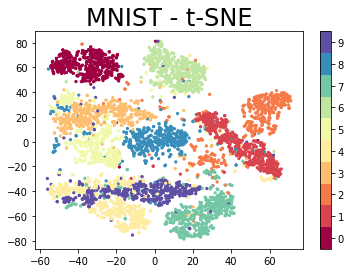

In [57]:
plt.scatter(tsne_res[:, 0], tsne_res[:, 1], s= 5, c=train_y, cmap='Spectral')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('MNIST - t-SNE', fontsize=24);

# Cnn

In [58]:
# преобразовать тензор в np.array
numpy_img = trainloader.dataset.train_data[0].numpy()

/zfs/store5.hydra.local/user/a/aimspot/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


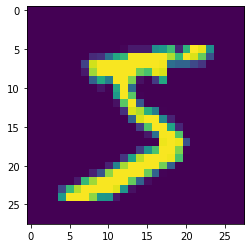

In [60]:
plt.imshow(numpy_img)

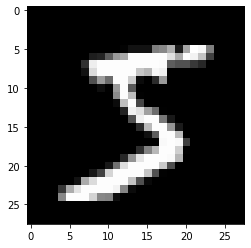

In [62]:
plt.imshow(numpy_img, cmap='gray')

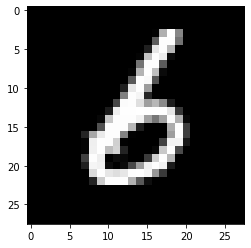

In [63]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=60000)

plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray');

In [97]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        print(x.shape)
        x = x.view(-1, 4 * 4 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [98]:
net = SimpleConvNet()

summary(net.cuda(), (1,28, 28))

torch.Size([2, 16, 4, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 24, 24]             208
         MaxPool2d-2            [-1, 8, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           3,216
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 45,278
Trainable params: 45,278
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.17
Estimated Total Size (MB): 0.23
----------------------------------------------------------------


In [92]:
from tqdm import tqdm_notebook

In [93]:
# объявляем сеть
net = SimpleConvNet().to(device)

In [94]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
losses = []

/tmp/ipykernel_81605/1619309692.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(2)):


  0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_81605/1619309692.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 0.969
[1,  4000] loss: 0.363
[1,  6000] loss: 0.284
[1,  8000] loss: 0.214
[1, 10000] loss: 0.197
[1, 12000] loss: 0.165
[1, 14000] loss: 0.144


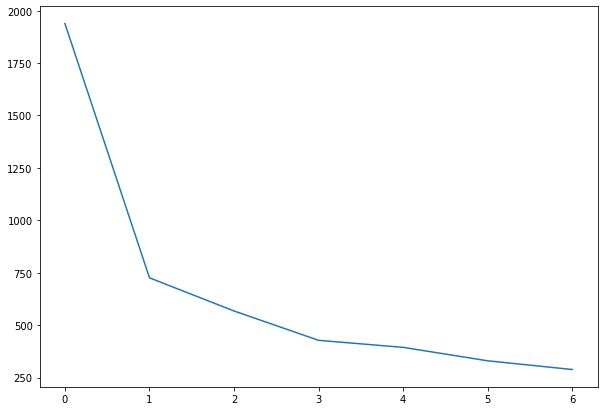

  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.121
[2,  4000] loss: 0.116
[2,  6000] loss: 0.112
[2,  8000] loss: 0.113
[2, 10000] loss: 0.098
[2, 12000] loss: 0.092
[2, 14000] loss: 0.094
Обучение закончено


In [95]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

# итерируемся
for epoch in tqdm_notebook(range(2)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            losses.append(running_loss)
            running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

In [96]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 98 %
Accuracy of   car : 98 %
Accuracy of  bird : 98 %
Accuracy of   cat : 96 %
Accuracy of  deer : 98 %
Accuracy of   dog : 97 %
Accuracy of  frog : 97 %
Accuracy of horse : 98 %
Accuracy of  ship : 97 %
Accuracy of truck : 96 %


# CIFAR-10

In [85]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


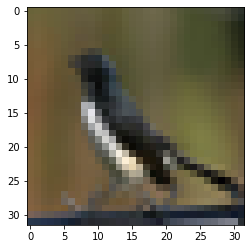

In [86]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=50000)

plt.imshow(trainloader.dataset.data[i], cmap='gray');